# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Example 4: Portfolio management


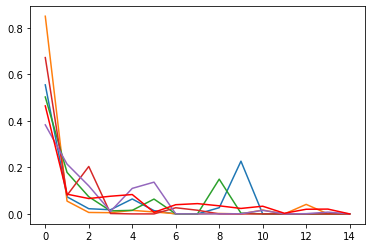

In [2]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.08)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(t,x,p,alpha, data,mu=1000,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return t + 0.05*torch.norm(x-p,1) + torch.tensor(l)*(sums - torch.tensor(target)) + torch.tensor(mu/2)*(sums - torch.tensor(target))**2, t + 0.05*torch.norm(x-p,1), totsum/Nsample, sums.detach().numpy()

n = 15
N = 500
seed = 15
np.random.seed(seed)
data = data_modes(1000,n,[1,2,3],seed = seed)
dist = (np.array([250,100,60,50,40,30,30,20,20,15,10,10,10,10,10,10])/100)[:n]
#dist = np.ones(n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = np.reshape(np.random.dirichlet(dist,1),(n,))

for i in range(num_scenarios):
  plt.plot(scenarios[i][0])

x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t)

constraints = [-data@x <= t,cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
plt.plot(x.value, color = "red")

In [3]:
data = data_modes(1000,n,[1,2,3],seed = 1)
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 1)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

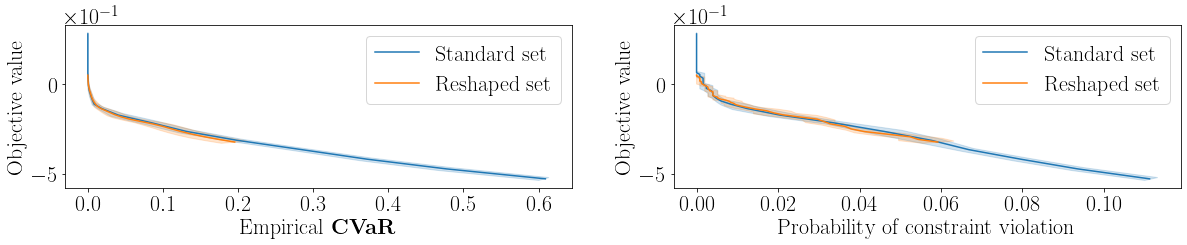

In [71]:
plot_tradeoff(dfgrid,dfgrid2,"Port",ind_1 = (12,100), ind_2 = (10,100))

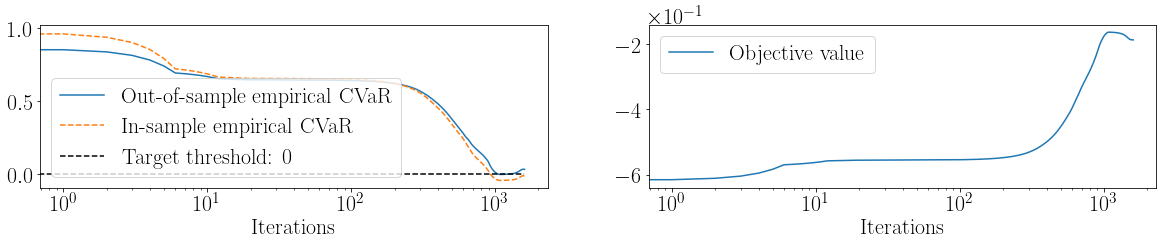

In [72]:
plot_iters(df1,"Port",logscale = 1)

In [3]:
def eval(t,x,p, data):
    t = torch.tensor(t)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    sums = 0
    totsum = torch.sum(torch.where(torch.maximum(-data@x - t, torch.tensor(0.,requires_grad = True))>= 0.0001,torch.tensor(1.), torch.tensor(0.)))
    Nsample = data.shape[0]
    return totsum/Nsample

def make_table(result_A, result_b, df,test,train,value = 0., eps = 1,cvar_train = 0, cvar_test = 0):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
            r_eps = 1
        else:
            r_eps = df['Eps'][np.absolute(np.mean(np.vstack(df['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(n,
                                        uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                        rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        trial1[scene,0] = newprob.objective.value
        trial1[scene,1] = eval(t.value, x.value, p.value, test).item()
        trial1[scene,2] = eval(t.value, x.value, p.value, train).item()
        trial1[scene,3] = cvar_train
        trial1[scene,4] = cvar_test
        trial1[scene,5] = newprob.solver_stats.solve_time
    return trial1

In [60]:
Ar_saved = np.zeros((100,n,n))
br_saved = np.zeros((100,n))
As_saved = np.zeros((100,n,n))
bs_saved = np.zeros((100,n))
reshaped_table = np.zeros((1,24))
standard_table = np.zeros((1,24))
for experiment in range(100):
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    
    # Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(n)
    t = cp.Variable()
    p = cp.Parameter(n)
    p.value = scenarios[0][0]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

    constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    target = -0.01
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    result1 = prob.train(lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 1)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    result3 = prob.train(eps = True, lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    df_r2 = result3.df
    As_saved[experiment,:] = result3.A
    bs_saved[experiment,:] = result3.b

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(0.01, 3, 60), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(0.01, 3, 60), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.048, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0., eps = 1, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.01, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t3 = make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t = np.hstack((r_t, r_t1, r_t2, r_t3))
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(result3.A,result3.b, dfgrid,test,train, 0.048, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t1 = make_table(result3.A,result3.b, dfgrid,test,train, 0., eps = 1,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t2 = make_table(result3.A,result3.b, dfgrid,test,train, 0.01, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t3 = make_table(result3.A,result3.b, dfgrid,test,train, 0.03, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t = np.hstack((s_t, s_t1, s_t2, s_t3))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table_2.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table_2.csv")
    np.save("Ar_saved.npy", Ar_saved)
    np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    np.save("bs_saved.npy", bs_saved)
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

In [47]:
print("test_vio_target: ", np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(reshaped_table[:,20].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(reshaped_table[:,18].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(reshaped_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(reshaped_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(reshaped_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.032320000089704946 
train_vio_target:  0.02984800047054882 
test_obj_target:  -0.19240147635945815 
test_vio:  0.016500000087078623 
train_vio:  0.012968000161461489 
test_obj:  -0.133561500314037 
test_cvar:  -0.0018806079707282674 
train_cvar:  -0.01053792247177647


In [19]:
np.mean(np.mean(reshaped_table[:,5].reshape(-1, 5), axis=1)), np.mean(np.mean(reshaped_table[:,23].reshape(-1, 5), axis=1))

(0.000612351928, 0.000590489252)

In [80]:
table = np.zeros((4,6))
table[0,0] =  np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1))
table[1,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1))
table[2,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,0] =  np.mean(np.mean(reshaped_table[:,11].reshape(-1, 5), axis=1))

table[0,1] =  np.mean(np.mean(reshaped_table[:,18].reshape(-1, 5), axis=1))
table[1,1] =  np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1))
table[2,1] =  np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1) >= 0.05)
table[3,1] =  np.mean(np.mean(reshaped_table[:,23].reshape(-1, 5), axis=1))

table[0,2] =  np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1))
table[1,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1))
table[2,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,2] =  np.mean(np.mean(standard_table[:,11].reshape(-1, 5), axis=1))

table[0,3] =  np.mean(np.mean(standard_table[:,18].reshape(-1, 5), axis=1))
table[1,3] =  np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1))
table[2,3] =  np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1) >= 0.05)
table[3,3] =  np.mean(np.mean(standard_table[:,23].reshape(-1, 5), axis=1))

table[0,4] =  np.mean(totalobjs,axis = 0)[11]
table[1,4] =  np.mean(totalvios, axis = 0)[11]
table[2,4] =  np.mean(np.mean(totalvios[:,11].reshape(-1, 5), axis=1) >= 0.05)
table[3,4] =  np.mean(totaltime, axis = 0)[11]

table[0,5] =  np.mean(sg_vals[:,1])
table[1,5] =  np.mean(sg_vals[:,0])
table[2,5] =  np.mean(sg_vals[:,0] >= 0.05)
table[3,5] =  np.mean(sg_vals[:,2])
pd.DataFrame(table).to_csv("table_vals.csv")


In [48]:
print("test_vio_target: ", np.mean(np.mean(standard_table[:,19].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(standard_table[:,20].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(standard_table[:,18].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(standard_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(standard_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(standard_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.028360000094398815 
train_vio_target:  0.03036800028011198 
test_obj_target:  -0.18076778619922051 
test_vio:  0.009460000155493581 
train_vio:  0.008612000132910864 
test_obj:  -0.10265505128871831 
test_cvar:  -0.007744786794471372 
train_cvar:  -0.010047478322100154


In [56]:
print(np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(np.mean(reshaped_table[:,19].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(sg_vals[:,0] >= 0.05))
print(np.mean(totalvios[:,11] >= 0.05))
print("reshaped = ", np.mean(reshaped_table[:,19]), np.mean(reshaped_table[:,18]),np.mean(reshaped_table[:,23]))
print("standard = ", np.mean(standard_table[:,19]), np.mean(standard_table[:,18]),np.mean(standard_table[:,23]))
print("DRO = ", np.mean(totalvios, axis = 0)[11] , np.mean(totalobjs,axis = 0)[11], np.mean(totaltime, axis = 0)[11])
print("SG = ", np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))

0.0
0.03
0.0
0.02
reshaped =  0.032320000089704946 -0.19240147635945815 0.0005904892519999999
standard =  0.028360000094398815 -0.18076778619922051 0.0005962162660000001
DRO =  0.030260000247508287 -0.17868645188190904 0.066244756972
SG =  0.01874000005889684 -0.1174466837627108 0.003907776084


In [36]:
def mro(train,test, K = 500, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(n,
                                        uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[0][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = newprob.objective.value
        vios_1[scene] = eval(t.value, x.value, p.value, train).item()
        vios[scene] = eval(t.value, x.value, p.value, test).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios,vios_1, objs, time

In [37]:
totalvios = np.zeros((num_scenarios*100,20))
totalvios_train = np.zeros((num_scenarios*100,20))
totalobjs = np.zeros((num_scenarios*100,20))
totaltime = np.zeros((num_scenarios*100,20))
epsrange = np.linspace(0.1, 5, 20)
for experiment in range(100):
    print(experiment)
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 500, rho = eps)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios2.npy", totalvios)
        np.save("totalvios_train2.npy", totalvios_train)
        np.save("totalobjs2.npy", totalobjs)
        np.save("totaltime2.npy", totaltime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


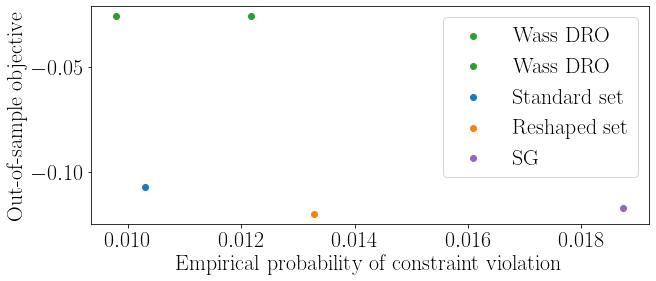

In [108]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totalvios_train, axis = 0)[13] , np.mean(totalobjs,axis = 0)[13], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(totalvios, axis = 0)[13] , np.mean(totalobjs,axis = 0)[13], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,13]), np.mean(standard_table[:,12]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,13]), np.mean(reshaped_table[:,12]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

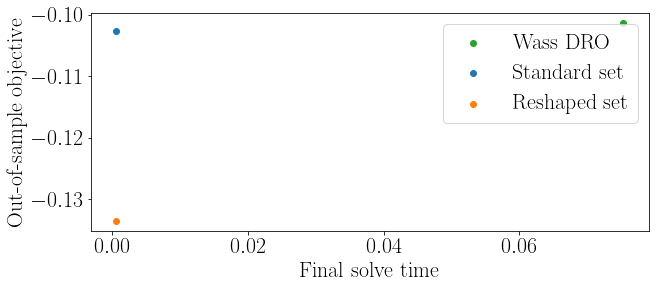

In [100]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totaltime, axis = 0)[12] , np.mean(totalobjs,axis = 0)[12], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,5]), np.mean(standard_table[:,6]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,5]), np.mean(reshaped_table[:,6]),label = "Reshaped set", color = "tab:orange")
# plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Final solve time")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

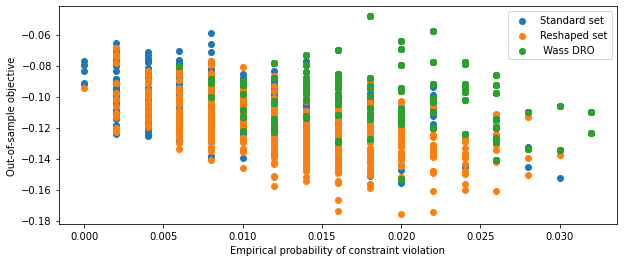

In [35]:
plt.figure(figsize = (10,4))
plt.scatter(standard_table[:,13], standard_table[:,12],label = "Standard set", color = "tab:blue")
plt.scatter(reshaped_table[:,13], reshaped_table[:,12],label = "Reshaped set", color = "tab:orange")
# plt.scatter(sg_vals[:,0], sg_vals[:,1],label = "SG", color = "tab:purple")
plt.scatter(totalvios[:,12] ,totalobjs[:,12], color = "tab:green", label = " Wass DRO")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [60]:
def sg(train,test):
    vios = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        # formulate cvxpy variable
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = scenarios[0][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))
        constraints = [cp.sum(x)==1, x >= 0]
        for u in train:
            constraints += [-x@u <= t]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        objs[scene] = prob.objective.value
        vios[scene] = eval(t.value, x.value, p.value, test).item()
        time[scene] = prob.solver_stats.solve_time
    return vios, objs, time

In [61]:
sg_vals = np.zeros((num_scenarios*100,3))
for experiment in range(100):
    print(experiment)
    data = data_modes(1000,n,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    vios, objs, time = sg(train,test)
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),0] = vios 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),1] = objs 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),2] = time
    np.save("sg_vals.npy", sg_vals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [4]:
standard_table = pd.read_csv("standard_table_2.csv").iloc[:,1:].values
reshaped_table = pd.read_csv("reshaped_table_2.csv").iloc[:,1:].values
totalvios = np.load("totalvios2.npy")
totalvios_train = np.load("totalvios_train2.npy")
totalobjs = np.load("totalobjs2.npy")
totaltime = np.load("totaltime2.npy")
sg_vals = np.load("sg_vals.npy")